In [1]:
import pickle
from google.colab import files
import tensorflow as tf

In [2]:
# Upload the "dataset.pkl" file to Colab
uploaded = files.upload()

# Load the data from the uploaded file
with open("dataset.pkl", "rb") as file:
    data = pickle.load(file)

# Extract the loaded data
time, carbodyvertacc11, carbodyvertacc12, carbodyvertacc21, carbodyvertacc22, roadvertheights = data

Saving dataset.pkl to dataset.pkl


# Loss functions

In [3]:

class MeanLessMeanSquaredError(tf.losses.Loss):
    def call(self, y_true, y_pred):
        y_true = y_true - tf.reduce_mean(y_true)
        y_pred = y_pred - tf.reduce_mean(y_pred)
        return tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)


# Define a custom Total Variation regularizer
class TotalVariationRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight=1.0):
        self.weight = weight

    def __call__(self, x):
        # Calculate the total variation loss for the kernel
        regularization = tf.reduce_sum(tf.image.total_variation(x))
        return self.weight * regularization


# Custom loss function for enforcing the "same road"
def same_road_loss(y_true, y_pred):
    regularizer_abs_error_diff = 0.1
    # Extract conv11 and conv21 from y_pred
    conv11 = y_pred[0]
    conv12 = y_pred[1]
    conv21 = y_pred[2]
    conv22 = y_pred[3]
    # Calculate the squared difference between estimations of the same road
    mean_squared_diff_road1 = tf.reduce_mean(tf.square(conv11 - conv21))
    mean_squared_diff_road2 = tf.reduce_mean(tf.square(conv12 - conv22))
    error_sum = mean_squared_diff_road1 + mean_squared_diff_road2
    error_abs_diff = tf.abs(mean_squared_diff_road1 - mean_squared_diff_road2)
    # Compute the mean squared difference
    return error_sum + regularizer_abs_error_diff * error_abs_diff


class SameRoadLossSimple:
    def __init__(self, amplitude_regularization: float = 1.0):
        self.amplitude_regularization = amplitude_regularization

    def __call__(self, y_true, y_pred, *args, **kwargs):
        # Compute the mean squared difference between the two predicted outputs
        shape_loss = tf.reduce_mean(tf.square(y_pred[0] - y_pred[1]))
        amplitude_loss = tf.abs(tf.reduce_mean(tf.square(y_pred[0])) - tf.reduce_mean(tf.square(y_pred[1])))
        return shape_loss + self.amplitude_regularization * amplitude_loss


class SameRoadLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, amplitude_regularization=1.0):
        super(SameRoadLossCallback, self).__init__()
        self.amplitude_regularization = amplitude_regularization
        self.x_val = x_val

    def on_epoch_end(self, epoch, logs=None):
        # Get the model
        model = self.model

        # Compute the predictions
        y_pred = model.predict(self.x_val)

        # Calculate the loss terms
        shape_loss = tf.reduce_mean(tf.square(y_pred[0] - y_pred[1]))
        amplitude_loss = tf.abs(tf.reduce_mean(tf.square(y_pred[0])) - tf.reduce_mean(tf.square(y_pred[1])))

        # Calculate the total loss
        total_loss = shape_loss + self.amplitude_regularization * amplitude_loss

        # Print the loss terms
        print(f"Epoch {epoch + 1} - Shape Loss: {shape_loss:.4f}, Amplitude Loss: {amplitude_loss:.4f}, Total Loss: {total_loss:.4f}")


# Predictive models

In [4]:
from typing import Union

from keras.models import Sequential
from keras.layers import Normalization
from keras.optimizers import Adam
from keras import regularizers, Input

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.src.layers import Conv1D, Lambda, Layer

In [5]:

def batch_extractor(time: np.ndarray, response: np.ndarray, batch_length_s: float, ret_time_batches: bool = False,
                    runing: bool = True, as_nparray: bool = False):
    time_batches = []
    response_batches = []
    if runing:
        batch_length = int(batch_length_s // (time[1] - time[0]))
        n_batches = len(time) - batch_length
    else:
        n_batches = int(time[-1] // batch_length_s)
        batch_length = int(len(time) // n_batches)
    for i_batch in range(n_batches):
        if runing:
            i_ini, i_fin = i_batch, i_batch + batch_length
        else:
            i_ini, i_fin = i_batch * batch_length, (i_batch + 1) * batch_length
        time_batches.append(time[i_ini:i_fin])
        response_batches.append(response[i_ini:i_fin])
    if ret_time_batches:
        if as_nparray:
            return np.array(response_batches), np.array(time_batches)
        else:
            return response_batches, time_batches
    else:
        if as_nparray:
            return np.array(response_batches)
        else:
            return response_batches


In [6]:

class JointIdentificationSimple:
    def __init__(self, x1, x2, time,
                 kernel_length_s: float = 5.0, batch_length_s: int = 10, learning_rate=0.001, epochs: int = 10,
                 amplitude_regularization: float = 1.0):
        """
        :param x1: measurement with car 1
        :param x2: measurement with car 2
        """
        self.amplitude_regularization = amplitude_regularization
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.x1 = x1
        self.x2 = x2
        self.time = time
        self.kernel_length_s = kernel_length_s
        self.batch_length_s = batch_length_s
        self.delta_t = time[1] - time[0]
        self.kernel_size = int(kernel_length_s / self.delta_t)

        self.model = None  # To be created in other methods

        self.x1_train, self.x1_time_batches = batch_extractor(self.time, self.x1, self.batch_length_s, runing=True,
                                                              ret_time_batches=True, as_nparray=True)
        self.x2_train, self.x2_time_batches = batch_extractor(self.time, self.x2, self.batch_length_s, runing=True,
                                                              ret_time_batches=True, as_nparray=True)

        self.y1_train = np.zeros(self.x1_train.shape)
        self.y2_train = np.zeros(self.x2_train.shape)

        self.batch_size = self.x1_train.shape[1]
        self.input_shape = (self.batch_size, 1)

    def build_model(self):
        # Define the input tensors
        input1 = Input(shape=self.input_shape)
        input2 = Input(shape=self.input_shape)

        # Apply shared Conv1D layers to each element of the input tensor
        conv1 = Conv1D(filters=1, use_bias=False, kernel_size=self.kernel_size,
                       activation='linear', padding='valid')(input1)
        conv2 = Conv1D(filters=1, use_bias=False, kernel_size=self.kernel_size,
                       activation='linear', padding='valid')(input2)

        # Create the model
        model = tf.keras.models.Model(inputs=[input1, input2],
                                      outputs=[conv1, conv2])

        # Compile the model and specify loss and optimizer as needed
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss=SameRoadLossSimple(amplitude_regularization=self.amplitude_regularization))

        # Print model summary
        model.summary()
        self.model = model

    def fit_model(self):
        self.model.fit([self.x1_train, self.x2_train], [self.y1_train, self.y2_train],
                       epochs=self.epochs, validation_split=0.1,
                       callbacks=[SameRoadLossCallback(x_val=[self.x1_train, self.x2_train],
                                                       amplitude_regularization=self.amplitude_regularization)])

    def predict(self, x1=None, x2=None):
        if x1 is not None:
            self.x1 = x1
            self.x1_train, self.x1_time_batches = batch_extractor(self.time, self.x1, self.batch_length_s,
                                                                  runing=True, ret_time_batches=True, as_nparray=True)
        if x2 is not None:
            self.x2 = x2
            self.x2_train, self.x2_time_batches = batch_extractor(self.time, self.x2, self.batch_length_s,
                                                                  runing=True, ret_time_batches=True, as_nparray=True)
        return self.model.predict([self.x1_train, self.x2_train])


# Training dataset

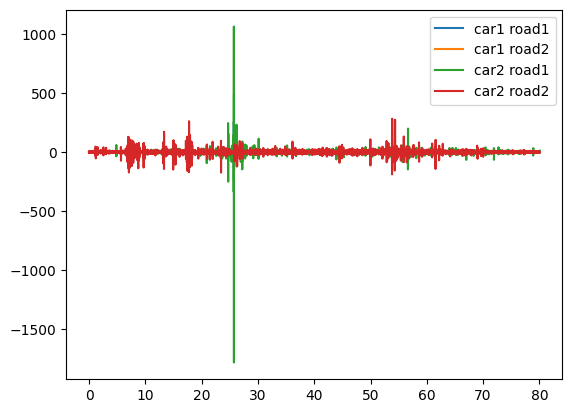

In [7]:
plt.figure()
plt.plot(time, carbodyvertacc11, label='car1 road1')
plt.plot(time, carbodyvertacc12, label='car1 road2')
plt.plot(time, carbodyvertacc21, label='car2 road1')
plt.plot(time, carbodyvertacc22, label='car2 road2')
plt.legend()
plt.show()


# Train

## JointIdentificationSimple


In [8]:
ji_s = JointIdentificationSimple(x1=np.hstack((carbodyvertacc11, carbodyvertacc12)),
                                 x2=np.hstack((carbodyvertacc21, carbodyvertacc22)),
                                 time=np.hstack((time, time+time[-1])),
                                 learning_rate=0.0001, epochs=500,
                                 amplitude_regularization=100.)  # x_car
ji_s.build_model()
ji_s.fit_model()
y_pred_s = ji_s.predict()
roads_s = [np.zeros((y_pred_.shape[1] + y_pred_.shape[0],)) for y_pred_ in y_pred_s]
y_pred_cols_s = y_pred_s[0].shape[1]
road_length_s = y_pred_s[0].shape[1] + y_pred_s[0].shape[0] - 1
for i_road, y_pred_ in zip(range(len(y_pred_s)), y_pred_s):
    for i in range(0, road_length_s - y_pred_cols_s, y_pred_cols_s):
        roads_s[i_road][i:i + y_pred_cols_s] = y_pred_[i, :, 0]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 999, 1)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 999, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 500, 1)               500       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 500, 1)               500       ['input_2[0][0]']             
                                                                                              

## Plot training results

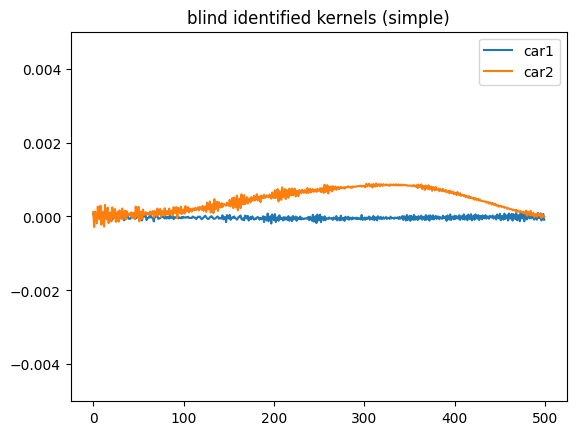

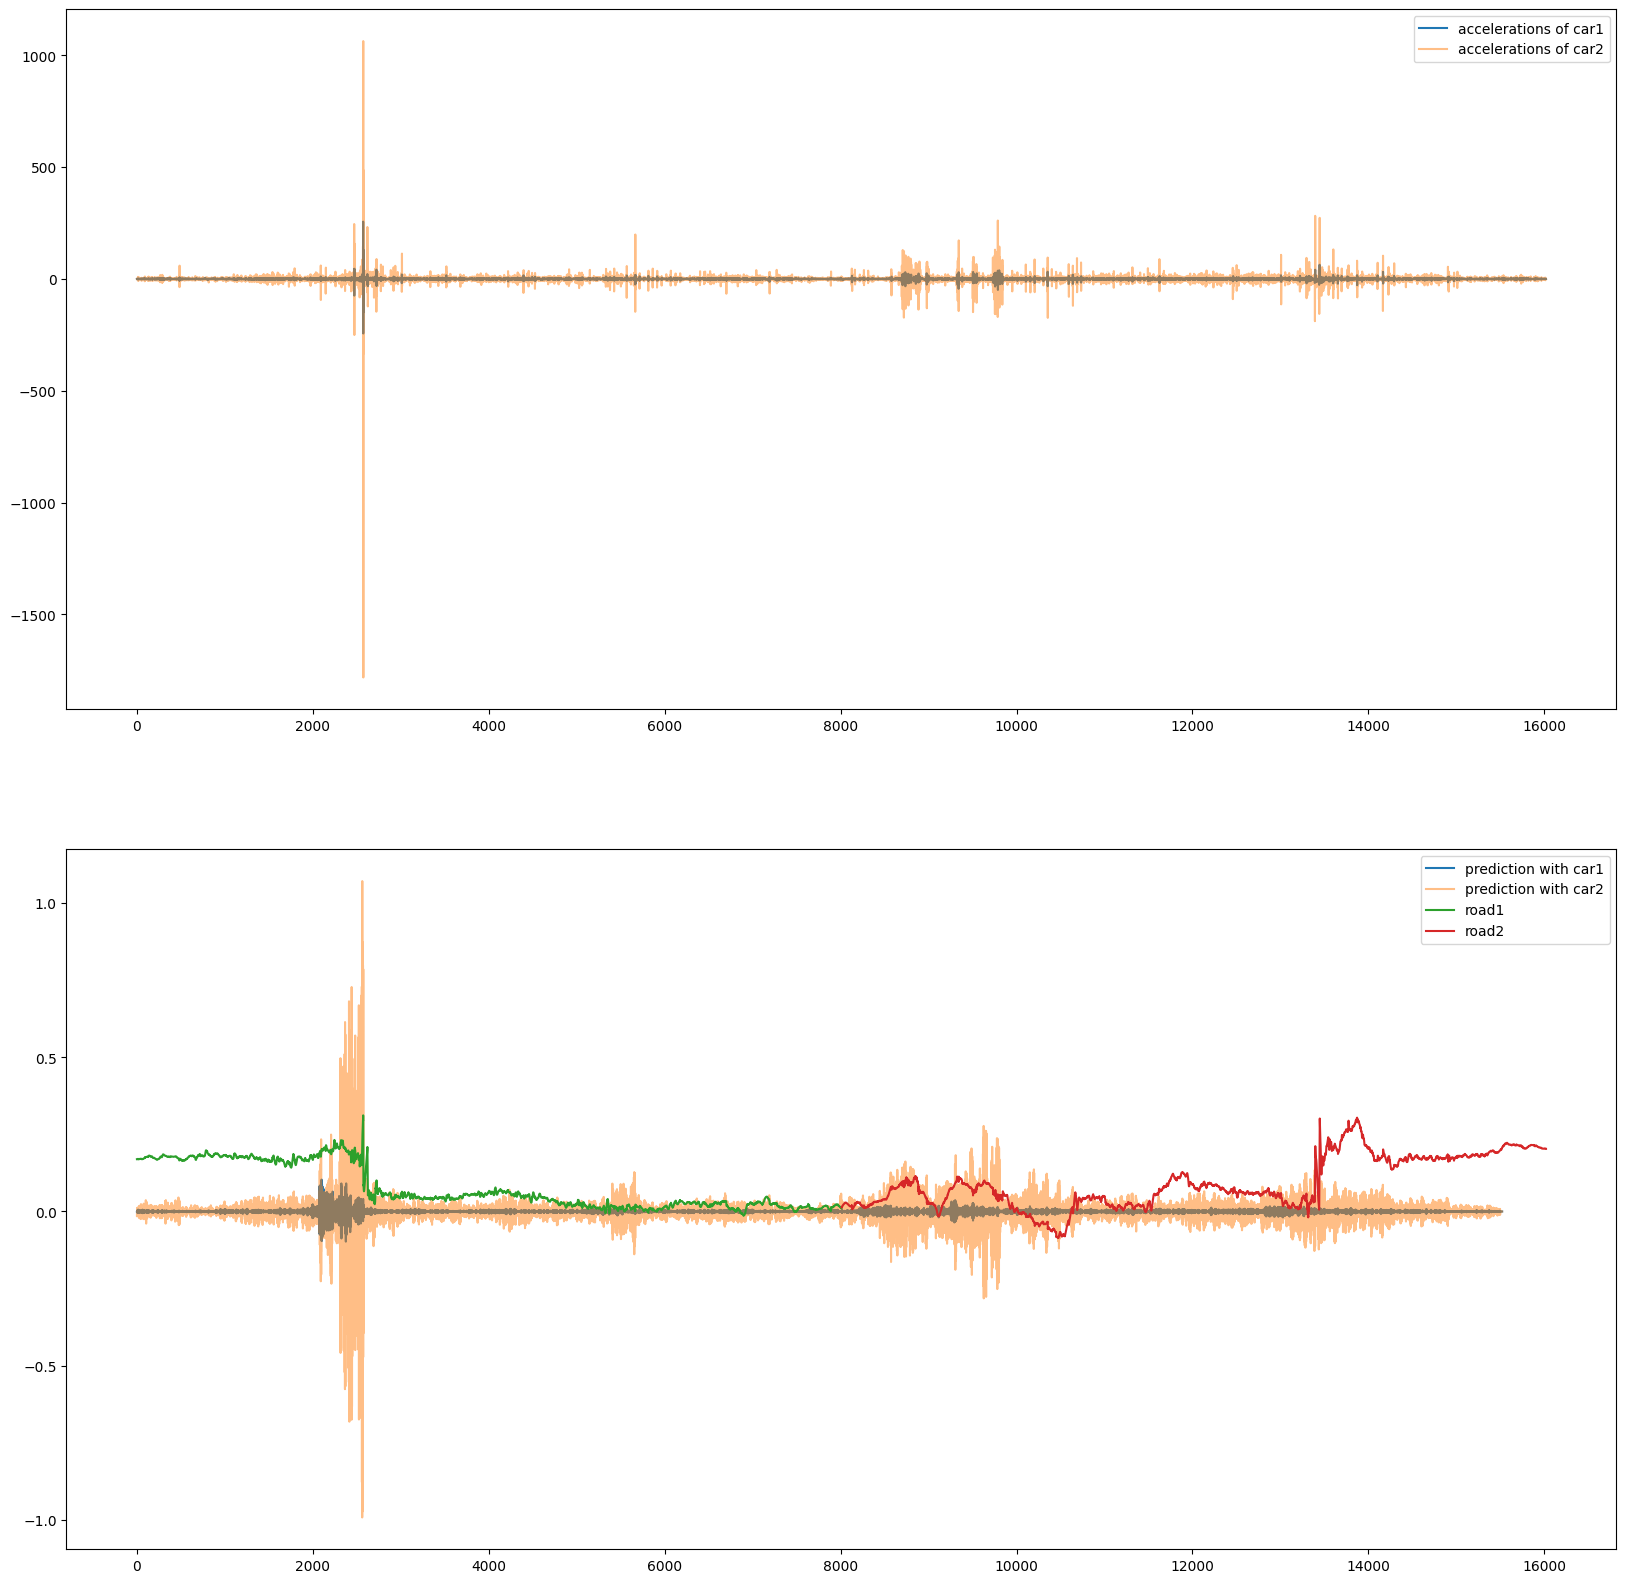

In [9]:
timesteps_skip = 10

plt.figure()
plt.title('blind identified kernels (simple)')
plt.plot(np.reshape(ji_s.model.weights[0], (-1,)), label='car1')
plt.plot(np.reshape(ji_s.model.weights[1], (-1,)), label='car2')
plt.legend()
plt.ylim([-.005, .005])
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(20,20))
ax[0].plot(ji_s.x1, label='accelerations of car1')
ax[0].plot(ji_s.x2, alpha=0.5, label='accelerations of car2')
ax[1].plot(roads_s[0], label='prediction with car1')
ax[1].plot(roads_s[1], alpha=0.5, label='prediction with car2')
road1_length = len(roadvertheights[1][0::timesteps_skip])
ax[1].plot(range(road1_length), roadvertheights[1][0::timesteps_skip], label='road1')
ax[1].plot(np.array(range(road1_length)) + road1_length, roadvertheights[2][0::timesteps_skip], label='road2')
ax[0].legend()
ax[1].legend()
plt.show()
